# stroke-alert

**Predictable variable: stroke**  
Aiming to early predict and alert the stroke risk based on individual's demographical or health data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pointbiserialr
import numpy as np

Original data:

In [42]:
df = pd.read_csv("AVC.csv")
df_original = df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5105 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5105 non-null   int32  
 1   age                5105 non-null   float64
 2   hypertension       5105 non-null   int64  
 3   heart_disease      5105 non-null   int64  
 4   work_type          5105 non-null   int32  
 5   Residence_type     5105 non-null   int32  
 6   avg_glucose_level  5105 non-null   float64
 7   bmi                4904 non-null   float64
 8   smoking_status     5105 non-null   int32  
 9   stroke             5105 non-null   int64  
dtypes: float64(3), int32(4), int64(3)
memory usage: 358.9 KB


### Initial data cleaning

Converting categorical variables to numerical representations

In [5]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Apply label encoding to the categorical variables
encoder = LabelEncoder()
df[categorical_vars] = df[categorical_vars].apply(encoder.fit_transform)

Deleting columns:  
- ID,  
- ever_married

Records:  
- where BMI values are superior to 69

Correlation between ever_married and age: **68%**

In [6]:
continuous_var = 'age'

binary_var = 'ever_married'

print(f'Point-biserial correlation coefficients for {continuous_var}:')
correlation_coefficient, p_value = pointbiserialr(df[continuous_var], df[binary_var])
print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')


Point-biserial correlation coefficients for age:
ever_married: 0.6791 (p-value: 0.0000)


Deleting columns ID, ever_married, records where BMI values are superior to 69:

In [7]:
df = df.drop('id', axis=1)
df = df.drop('ever_married', axis=1)
df = df.drop(df[df['bmi'] >= 69].index) #IMC de 59 correspond à 170cm 200 Kg, les valeurs max sont à 97,6 (abérant)

Data records where BMI >= 69 (from original dataframe):

In [8]:
high_bmi_df = df_original[(df_original['bmi'] >= 69)]
high_bmi_df.sort_values(by='bmi', ascending=False)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
544,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0


Changing 'smoking_status' 0 ('Unknown') values to null:

In [9]:
# df['smoking_status'] = df['smoking_status'].replace(0, None)

### Gender

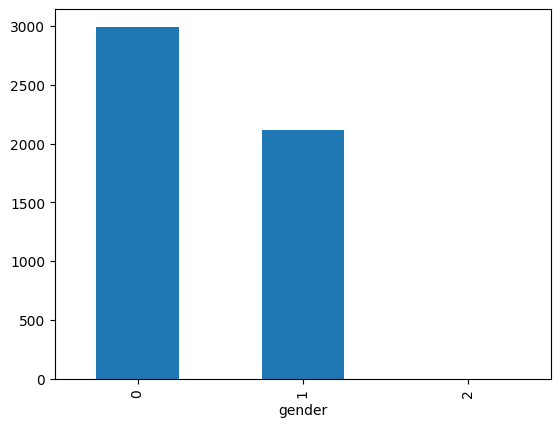

In [10]:
df.gender.value_counts().plot(kind='bar')
plt.show()

Removing 1 data sample with gender 'Other' (2)

In [11]:
df = df.drop(df[df['gender'] == 2].index)

### Residence type

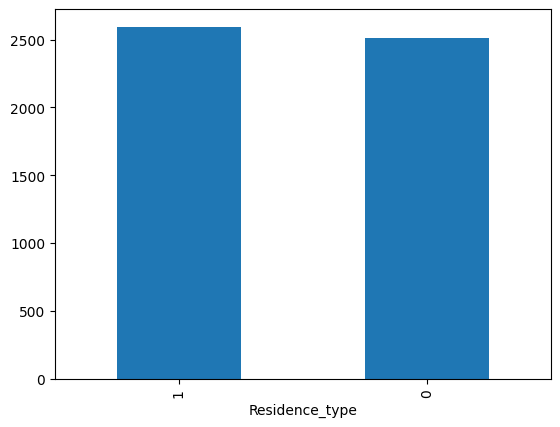

In [12]:
df.Residence_type.value_counts().plot(kind='bar')
plt.show()

### Work type

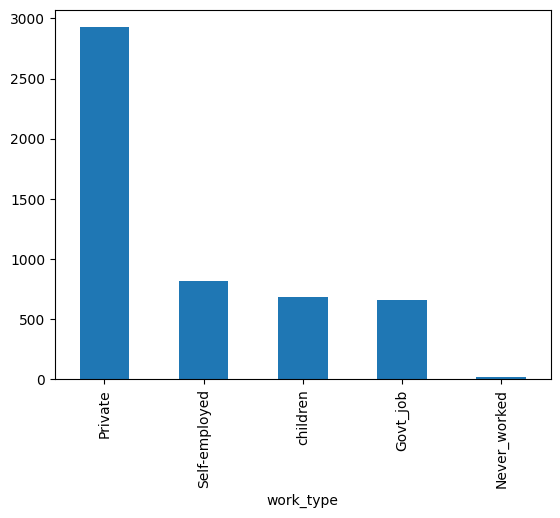

In [13]:
df_original.work_type.value_counts().plot(kind='bar')
plt.show()

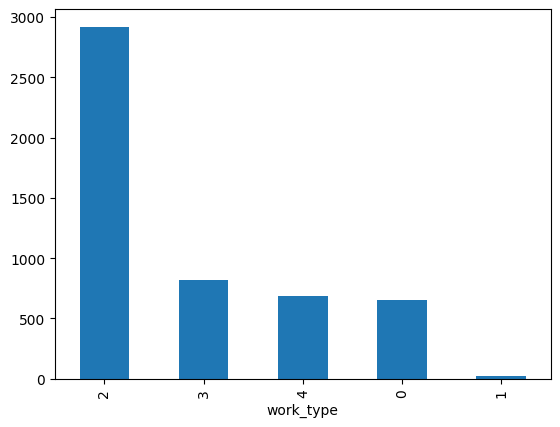

In [14]:
df.work_type.value_counts().plot(kind='bar')
plt.show()

### Smoking status

Original data:

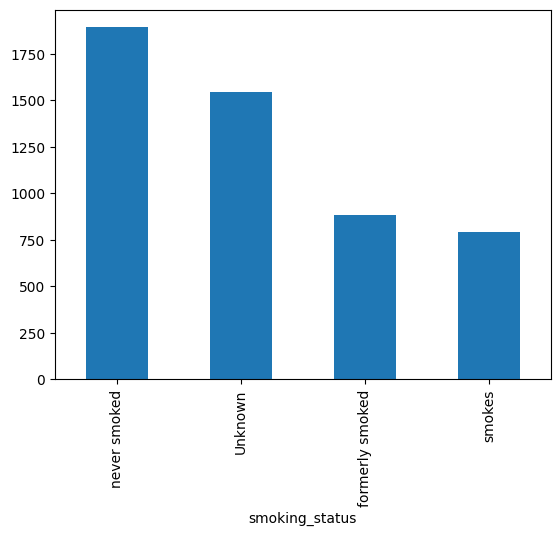

In [15]:
df_original.smoking_status.value_counts().plot(kind='bar')
plt.show()

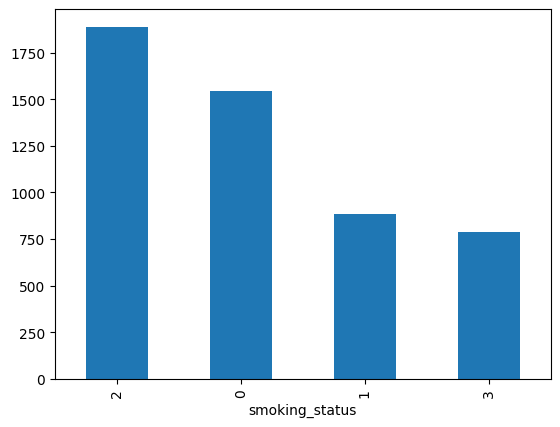

In [16]:
df.smoking_status.value_counts().plot(kind='bar')
plt.show()

### Hypertension

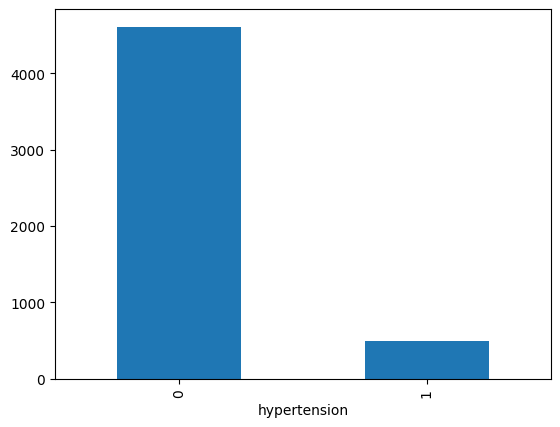

In [17]:
df.hypertension.value_counts().plot(kind='bar')
plt.show()

### Heart disease

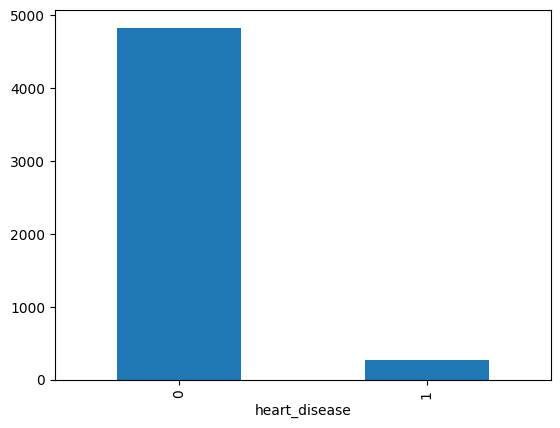

In [18]:
df.heart_disease.value_counts().plot(kind='bar')
plt.show()

### Stroke

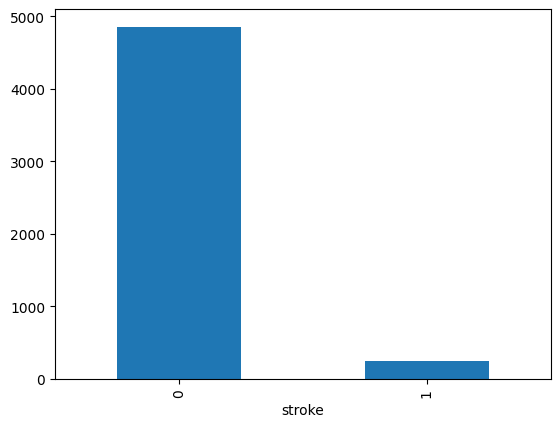

In [19]:
df.stroke.value_counts().plot(kind='bar')
plt.show()

### Age

Data distribution:

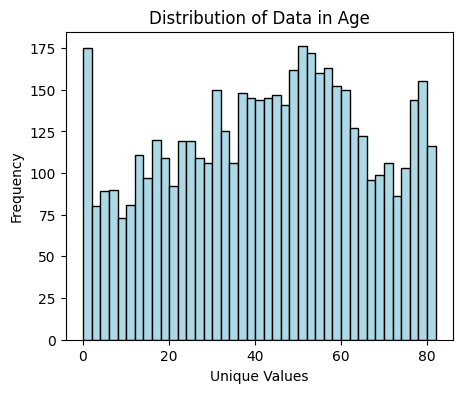

In [55]:
plt.figure(figsize=(5, 4))
plt.hist(df['age'], bins=41, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Age')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Calculating the histogram bin edges

In [53]:
# Calculate histogram values and bin edges
hist_values, bin_edges = np.histogram(df['age'], bins=41, range=(df['age'].min(), df['age'].max()))

# Assign histogram bins to DataFrame
df['age_histogram'] = np.digitize(df['age'], bins=bin_edges)

# Print start and end points of each bin
for i, (start, end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    print(f'Bin {i + 1}: Start: {start}, End: {end}')

Bin 1: Start: 0.08, End: 2.078048780487805
Bin 2: Start: 2.078048780487805, End: 4.07609756097561
Bin 3: Start: 4.07609756097561, End: 6.074146341463415
Bin 4: Start: 6.074146341463415, End: 8.07219512195122
Bin 5: Start: 8.07219512195122, End: 10.070243902439024
Bin 6: Start: 10.070243902439024, End: 12.06829268292683
Bin 7: Start: 12.06829268292683, End: 14.066341463414634
Bin 8: Start: 14.066341463414634, End: 16.064390243902437
Bin 9: Start: 16.064390243902437, End: 18.062439024390244
Bin 10: Start: 18.062439024390244, End: 20.060487804878047
Bin 11: Start: 20.060487804878047, End: 22.05853658536585
Bin 12: Start: 22.05853658536585, End: 24.056585365853657
Bin 13: Start: 24.056585365853657, End: 26.054634146341463
Bin 14: Start: 26.054634146341463, End: 28.052682926829267
Bin 15: Start: 28.052682926829267, End: 30.05073170731707
Bin 16: Start: 30.05073170731707, End: 32.048780487804876
Bin 17: Start: 32.048780487804876, End: 34.04682926829268
Bin 18: Start: 34.04682926829268, End: 

Age < 2.08 (first histogram bin) - values where stroke = 1: 

In [58]:
test_df = df[(df['age'] <= 2.08) & (df['stroke'] == 1)]
test_df.sort_values(by='age', ascending=False)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1,1


Age < 2.08 (first histogram bin) - all values: 

In [61]:
test_df = df[(df['age'] <= 2.08)]
test_df.sort_values(by='age', ascending=False)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_histogram


**Deleting the records where age < 2.08** (175 records)

In [60]:
df = df.drop(df[df['age'] <= 2.08].index)

## Correlation & Association

#### Continuous variables

In [20]:
df[['age','avg_glucose_level','bmi']].describe()

,age,avg_glucose_level,bmi
count,5105.000000,5105.000000,4904.000000
mean,43.240353,106.145391,28.848899
std,22.617555,45.266850,7.687300
min,0.080000,55.120000,10.300000
25%,25.000000,77.280000,23.500000
50%,45.000000,91.890000,28.000000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,66.800000


#### Categorical variables (binary & nominal)

In [40]:
continuous_data_columns = ['age', 'avg_glucose_level', 'bmi']
df_categorical_data = df.drop(columns=continuous_data_columns)
df_categorical_data.head()

,gender,hypertension,heart_disease,work_type,Residence_type,smoking_status,stroke
0,1,0,1,2,1,1,1
1,0,0,0,3,0,2,1
2,1,0,1,2,0,2,1
3,0,0,0,2,1,3,1
4,0,1,0,3,0,2,1


#### Heatmap

In [44]:
cor = df.corr()
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot=True,ax=ax,cmap='coolwarm');

ValueError: could not convert string to float: 'Male'

In [23]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,3,0,202.21,NaN,2,1
2,1,80.0,0,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,2,1,171.23,34.4,3,1
4,0,79.0,1,0,3,0,174.12,24.0,2,1


In [24]:
# sns.pairplot(df,kind="kde")

#### Correlation between categorical binary variable *stroke* and continuous variables *age*, *glucose_level*, and *bmi*

#### Correlation between categorical binary variable *stroke* and categorical binary & nominal variables *gender*, *hypertension*, *heart_disease*, *Residence_type*, *work_type*, and *smoking_status*

## Supervised classification (with 1 feature)

- **Splitting the DataFrame into training and testing sets**,  
- **Standardizing the features** using StandardScaler() to ensure they have a mean of 0 and a standard deviation of 1.
- Testing data set = 20%

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis=1),df['stroke'],test_size = .2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### -- Random Forrest

##### Algorithm

In [43]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


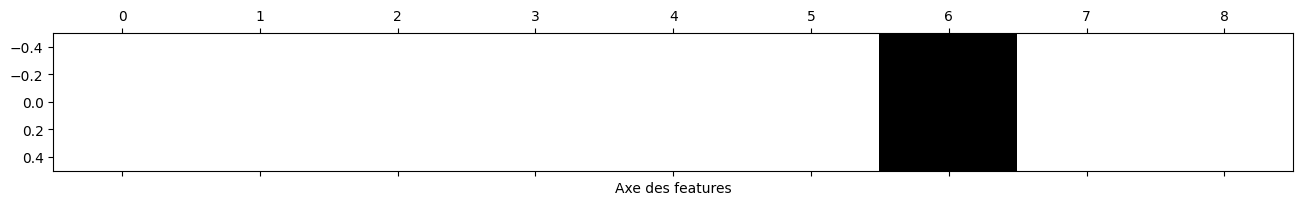

In [27]:
rfc1 = RandomForestClassifier()
rfe = RFE(estimator=rfc1, step=1, n_features_to_select = 1)
rfe.fit(X_train, y_train)
mask = rfe.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');


In [28]:
mask

array([False, False, False, False, False, False,  True, False, False])

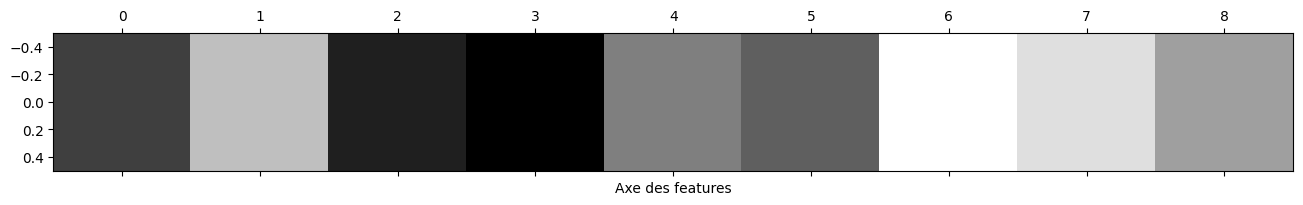

In [29]:
ranking = rfe.ranking_
plt.matshow(ranking.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

In [30]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,3,0,202.21,NaN,2,1
2,1,80.0,0,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,2,1,171.23,34.4,3,1
4,0,79.0,1,0,3,0,174.12,24.0,2,1


##### Evaluation

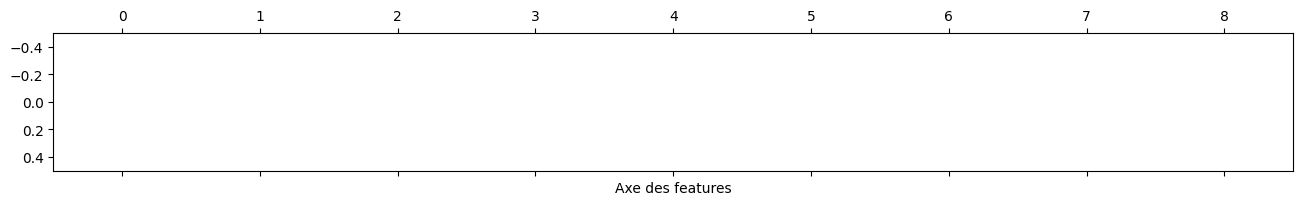

In [31]:
lm = LinearRegression()
rfc = RandomForestClassifier()

crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=rfc, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

mask = rfecv.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();


Nombre de features retenus : 9


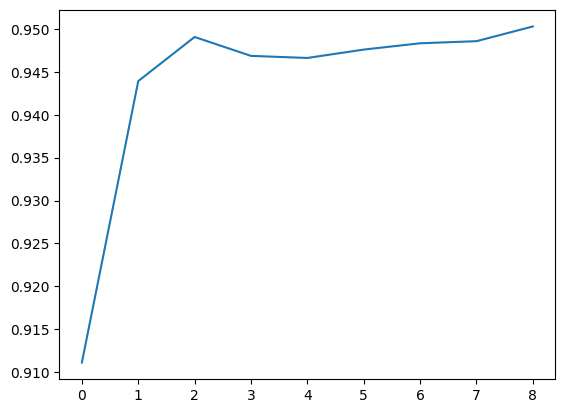

In [32]:
plt.plot(rfecv.cv_results_['mean_test_score']);
print("Nombre de features retenus :", rfecv.n_features_)

In [33]:
rfecv.cv_results_['mean_test_score']

array([0.91111761, 0.94392625, 0.94906881, 0.94686533, 0.94662113,
       0.94759942, 0.94833441, 0.94857861, 0.9502934 ])

#### -- Other Algorithm

##### Algorithm

In [34]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,3,0,202.21,NaN,2,1
2,1,80.0,0,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,2,1,171.23,34.4,3,1
4,0,79.0,1,0,3,0,174.12,24.0,2,1


##### Evaluation

#### -- Other Algorithm

##### Algorithm

##### Evaluation

## Supervised classification (with multiple features)

## Notes

In [35]:
#séparer correlation variable continu/discontinu et pearson ou dautre metrics

In [36]:
#fumeur unknown : cb sont stroke ? si 0 ou très peu : delete !?

In [37]:
#enelver enfant sous 8ans